In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import requests
from pandas_datareader import wb  
import datetime as dt
from pandas_datareader import data
import pandas_datareader.data as dtr
import yfinance as yfin

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Θα κατεβάσουμε δεδομένα απο ορισμένες μετοχές

In [2]:
stocks = ['GOOGL', 'TM', 'KO', 'PEP']
numAssets = len(stocks)

start=dt.datetime(2019, 1, 2)
end=dt.datetime(2019, 12, 31)


H ακόλουθη συνάρτηση θα κατεβάσει τα δεδομένα

In [5]:
def read_data_adj(ticker_list,
          start=dt.datetime(2019, 1, 2),
          end=dt.datetime(2019, 12, 31)):
  
    ticker = pd.DataFrame()      # initialize the data frame

    for symbol in stocks:
        yfin.pdr_override()
        prices = dtr.get_data_yahoo(symbol,start,end)
         #prices = data.DataReader(symbol, 'yahoo', start, end)
        adj_prices = prices['Adj Close']
        ticker[symbol] = adj_prices

    return ticker



In [6]:
data=read_data_adj(stocks)


rets = np.log(data / data.shift(1))   # generate logreturns


# daily returns and volatility if you want yearly multiply by 252
mu=rets.mean()   
A=rets.cov()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
print(mu)
print(A)

GOOGL    0.000957
TM       0.000760
KO       0.000779
PEP      0.001016
dtype: float64
          GOOGL        TM        KO       PEP
GOOGL  0.000223  0.000050  0.000034  0.000045
TM     0.000050  0.000073  0.000017  0.000023
KO     0.000034  0.000017  0.000117  0.000057
PEP    0.000045  0.000023  0.000057  0.000076


In [8]:

import scipy.optimize as sco

# define a function providing the expected variance of the
# portfolio

def variance(weights,A):
    var=np.dot(weights.T,np.dot(A,weights)) 
    return var

def sharpe_ratio_neg(weights,A,mu,risk_free):
    var=variance(weights,A)
    expected_return=np.dot(mu,weights)
    sharpe_neg=-(expected_return-risk_free)/var
    return sharpe_neg

def constraints_fun(weights,A,mu,mean_return_required):
    # mu is the return vector
    # A is the covariance matrix
    # mean_return_required is the required mean return
    n_assets=len(mu)
    c1=np.dot(weights,mu)-mean_return_required
    c2=np.dot(np.ones(n_assets),weights)-1
    return c1,c2

def find_min_con_2(A,mu,mean_return_required):
    n_assets=len(mu)
    x_0=(1/n_assets)*np.ones(n_assets)
    args=(A)
    bounds=()   # empty bounds object for now
    # we need to call the constraint function and consider it as a
    # function of weights only
    constraints = ({'type': 'eq', 'fun': lambda x: constraints_fun(x,A,mu,mean_return_required)[0]},
                   {'type': 'eq', 'fun': lambda x: constraints_fun(x,A,mu,mean_return_required)[1]})
    opts = sco.minimize(variance,x_0,args=args,method='SLSQP', bounds=bounds, constraints=constraints)
    return opts




In [9]:
mean_return_required=0.00085

find_min_con_2(A,mu,mean_return_required)



     fun: 5.562766421636753e-05
     jac: array([1.59266910e-04, 8.49381217e-05, 1.15943695e-04, 9.42005031e-05])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.20490552, 0.31729098, 0.30635942, 0.17144408])

In [10]:
# suppose you want just the minimum

res=find_min_con_2(A,mu,mean_return_required)
solution=res.x




In [11]:
print(solution)

[0.20490552 0.31729098 0.30635942 0.17144408]


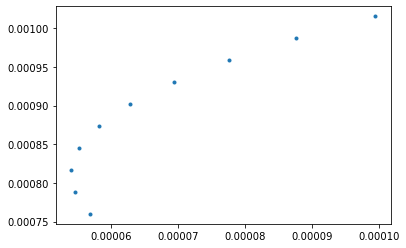

In [12]:
#  now draw the characteristic frontier

N_points=10
mu_required=np.linspace(mu.min(),mu.max(),N_points)

mu_front=np.zeros(N_points)
var_front=np.zeros(N_points)

for i in range(N_points):
    res=find_min_con_2(A,mu,mu_required[i])
    opt_weight=res.x
    mu_front[i]=np.dot(opt_weight,mu)
    var_front[i]=np.dot(opt_weight.T,np.dot(A,opt_weight))

plt.plot(var_front,mu_front,'.')
